<a href="https://colab.research.google.com/github/Ak4nksha/ai-generated-text-detector/blob/main/notebooks/03_feature_engineering_and_baseline_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering & Baseline Models

**Objective:**
Extract advanced stylometric features and train a hybrid text classification model. **Crucially, this notebook implements a strict data splitting strategy to comply with project requirements regarding independent evaluation.**

**Key Workflow:**
1.  **Load Data:** Import `final_merged_dataset.csv` (from Notebook 2).
2.  **Strict Data Splitting (Project Compliance):**
    * **Test Set (Final Eval):** Composed *exclusively* of self-collected data (Wikipedia, ArXiv, News, ChatGPT)
    * **Training Set:** A mix of downsampled Kaggle data (for efficiency and diversity) and the remaining self-collected data.
    * **Validation Set:** Held-out Kaggle data for hyperparameter tuning.
3.  **Feature Engineering (Stylometry):**
    * **Lexical Diversity:** Type-Token Ratio (vocabulary richness).
    * **Readability:** Flesch-Kincaid, Gunning Fog scores.
    * **Structure:** Sentence length variance, punctuation patterns.
    * **Linguistic Analysis:** Part-of-Speech (POS) tagging via spaCy.
4.  **Hybrid Modeling:**
    * Combine **TF-IDF vectors** (content) with **Stylometric features** (style).
    * Train Baseline Models: Logistic Regression, Linear SVC, Random Forest.
5.  **Evaluation:** Report Precision/Recall on the held-out Test set and analyze model coefficients to interpret "AI-like" writing markers.

In [3]:
from google.colab import drive
drive.mount("/content/drive")

ValueError: Mountpoint must not already contain files

In [ ]:
# =========================
# Install all required libraries for this project
# =========================
!pip -q install -U \
  numpy pandas scipy \
  scikit-learn \
  matplotlib \
  tqdm \
  textstat \
  torch \
  transformers \
  datasets \
  accelerate
!python -m spacy download en_core_web_sm

In [ ]:
import re
import string
from collections import Counter

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re, math, hashlib, zlib
from collections import Counter

import textstat
import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tqdm.pandas()  # enable progress bar on apply

# load lightweight spaCy model
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Columns: Index(['text', 'label', 'doc_id', 'source'], dtype='object')
First few rows:


,text,label,doc_id,source
0,The Face in the picture was not created by ali...,0,kaggle_0,kaggle
1,Title: My Dream Career: Becoming a Software En...,1,kaggle_1,kaggle
2,Attending classes at home is not a great benef...,0,kaggle_2,kaggle
3,What's Your Opinion? By: Generic_Name Have you...,0,kaggle_3,kaggle
4,The exploration of nearby planets has always b...,1,kaggle_4,kaggle



Dataset shape: (505254, 4)

Label value counts:
label
0    311712
1    193542
Name: count, dtype: int64


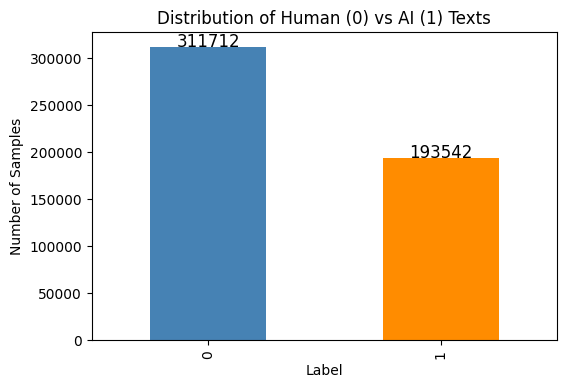

In [ ]:
CSV_PATH = "/content/drive/MyDrive/final_merged_dataset.csv"
TEXT_COL = "text"
LABEL_COL = "label"

# Robust CSV load (handles quotes, bad lines)
df = pd.read_csv(
    CSV_PATH,
    engine="python",
    escapechar="\\",
    on_bad_lines="skip"
)

# Drop rows with missing text/label
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()

# Clean label column: ensure numeric 0/1
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce")
df[LABEL_COL] = df[LABEL_COL].fillna(0).astype(int)

#additional fixes for NAN values
df["source"] = df["source"].fillna("kaggle")
nan_rows = df['doc_id'].isna()
df.loc[nan_rows, 'doc_id'] = "kaggle_" + df.loc[nan_rows].index.astype(str)


print("Columns:", df.columns)
print("First few rows:")
display(df.head())
print(f"\nDataset shape: {df.shape}")

print("\nLabel value counts:")
# Count class distribution
counts = df[LABEL_COL].value_counts().sort_index()
print(counts)


import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['steelblue', 'darkorange'])
plt.title("Distribution of Human (0) vs AI (1) Texts")
plt.xlabel("Label")
plt.ylabel("Number of Samples")

# Annotate bars with counts
for i, v in enumerate(counts):
    plt.text(i, v + 500, str(v), ha='center', fontsize=12)

plt.show()

In [ ]:
# =========================
# FINAL FEATURE WRAPPER CELL
# =========================

import re
from typing import Dict

# ---------- helpers ----------
def get_lines(text: str, max_lines: int):
    if not isinstance(text, str) or not text:
        return []
    return text.splitlines()[:max_lines]

def basic_counts(text: str):
    text = text or ""
    num_chars = len(text)

    # sentence split
    sentences = re.split(r"[.!?]+", text)
    sentences = [s.strip() for s in sentences if s.strip()]
    num_sent = len(sentences) if sentences else 1

    # word tokens
    words = re.findall(r"\w+", text)
    num_words = len(words) if words else 1

    avg_sent_len = num_words / num_sent
    return {
        "num_chars": num_chars,
        "num_words": num_words,
        "num_sentences": num_sent,
        "avg_sentence_length": avg_sent_len,
    }


def lexical_diversity(text: str):
    words = re.findall(r"\w+", str(text).lower())
    if not words:
        return {
            "type_token_ratio": 0.0,
            "unique_words": 0,
        }
    unique = set(words)
    ttr = len(unique) / len(words)
    return {
        "type_token_ratio": ttr,
        "unique_words": len(unique),
    }


def punctuation_stats(text: str):
    text = text or ""
    if not text:
        return {
            "pct_punct": 0.0,
            "pct_upper": 0.0,
            "pct_digit": 0.0,
        }
    total = len(text)
    punct = sum(ch in string.punctuation for ch in text)
    upper = sum(ch.isupper() for ch in text)
    digit = sum(ch.isdigit() for ch in text)
    return {
        "pct_punct": punct / total,
        "pct_upper": upper / total,
        "pct_digit": digit / total,
    }


def readability_features(text: str):
    clean = text if isinstance(text, str) else ""
    if len(clean.split()) < 3:
        return {
            "flesch_reading_ease": 0.0,
            "flesch_kincaid_grade": 0.0,
            "gunning_fog": 0.0,
        }
    try:
        fre = textstat.flesch_reading_ease(clean)
        fkg = textstat.flesch_kincaid_grade(clean)
        gf  = textstat.gunning_fog(clean)
    except Exception:
        fre, fkg, gf = 0.0, 0.0, 0.0
    return {
        "flesch_reading_ease": fre,
        "flesch_kincaid_grade": fkg,
        "gunning_fog": gf,
    }


def repetition_features(text: str):
    tokens = re.findall(r"\w+", str(text).lower())
    if len(tokens) < 4:
        return {"bigram_repetition_ratio": 0.0}
    bigrams = list(zip(tokens, tokens[1:]))
    total_bigrams = len(bigrams)
    counts = Counter(bigrams)
    repeated = sum(c for c in counts.values() if c > 1)
    return {
        "bigram_repetition_ratio": repeated / total_bigrams
    }


def pos_features_spacy(text: str):
    doc = nlp(str(text))
    tokens = [t for t in doc if not t.is_space]
    total_tokens = len(tokens)
    if total_tokens == 0:
        return {
            "pos_ratio_NOUN": 0.0,
            "pos_ratio_VERB": 0.0,
            "pos_ratio_ADJ": 0.0,
            "pos_ratio_ADV": 0.0,
            "pos_ratio_PRON": 0.0,
            "pos_ratio_ADP": 0.0,
            "pos_ratio_DET": 0.0,
        }
    counts = Counter(tok.pos_ for tok in tokens)

    def ratio(tag):
        return counts.get(tag, 0) / total_tokens

    return {
        "pos_ratio_NOUN": ratio("NOUN"),
        "pos_ratio_VERB": ratio("VERB"),
        "pos_ratio_ADJ":  ratio("ADJ"),
        "pos_ratio_ADV":  ratio("ADV"),
        "pos_ratio_PRON": ratio("PRON"),
        "pos_ratio_ADP":  ratio("ADP"),
        "pos_ratio_DET":  ratio("DET"),
    }


def sentence_length_stats(text: str):
    sentences = re.split(r"[.!?]+", str(text))
    sentences = [s.strip() for s in sentences if s.strip()]
    if len(sentences) < 2:
        return {
            "sentence_length_std": 0.0,
            "sentence_length_mean": len(str(text).split()),
        }
    lens = [len(s.split()) for s in sentences]
    return {
        "sentence_length_std": float(np.std(lens)),
        "sentence_length_mean": float(np.mean(lens)),
    }


def compute_all_features(text: str):
    feats = {}
    feats.update(basic_counts(text))
    feats.update(lexical_diversity(text))
    feats.update(punctuation_stats(text))
    feats.update(readability_features(text))
    feats.update(repetition_features(text))
    feats.update(pos_features_spacy(text))
    feats.update(sentence_length_stats(text))
    return feats

# ============================================================
# NEW FEATURES
# ============================================================

# --- A) Em-dash / emphasis punctuation ---
def emphasis_punctuation_features(text: str, max_lines: int = 5) -> Dict:
    lines = get_lines(text, max_lines)
    joined = "\n".join(lines)
    n = len(joined) if joined else 1

    return {
        "emdash_ratio": joined.count("—") / n,
        "double_dash_ratio": joined.count("--") / n,
        "colon_ratio_emphasis": joined.count(":") / n,
        "semicolon_ratio_emphasis": joined.count(";") / n,
        "emphasis_punctuation_ratio": (
            joined.count("—")
            + joined.count("--")
            + joined.count(":")
            + joined.count(";")
        ) / n,
    }


# --- B) Hedging / cautious language ---
HEDGE_PHRASES = [
    "some might argue",
    "it could be said",
    "it may be",
    "it might be",
    "it is possible that",
    "it appears that",
    "it seems that",
    "may suggest",
    "could suggest",
    "is often considered",
    "is generally regarded",
]

def hedging_language_features(text: str, max_lines: int = 5) -> Dict:
    lines = get_lines(text.lower(), max_lines)
    if not lines:
        return {
            "hedge_phrase_count": 0,
            "hedge_phrase_ratio": 0.0,
            "hedge_line_ratio": 0.0,
        }

    hedge_count = 0
    hedge_lines = 0

    for ln in lines:
        c = sum(ln.count(p) for p in HEDGE_PHRASES)
        if c > 0:
            hedge_count += c
            hedge_lines += 1

    total = len(lines)

    return {
        "hedge_phrase_count": hedge_count,
        "hedge_phrase_ratio": hedge_count / total,
        "hedge_line_ratio": hedge_lines / total,
    }


# --- C) Vague / hallucination-proxy language ---
GENERIC_CLAIMS = [
    "studies suggest",
    "research shows",
    "experts believe",
    "it is believed",
    "it is widely accepted",
]

VAGUE_QUANTIFIERS = [
    "various",
    "numerous",
    "several",
    "many",
    "a number of",
    "some",
]

FAKE_CITATION_PATTERNS = [
    r"\[\d+\]",        # [1], [23]
    r"\(\d{4}\)",      # (2021)
    r"et al\.",        # et al.
]

def vague_and_hallucination_features(text: str, max_lines: int = 5) -> Dict:
    lines = get_lines(text.lower(), max_lines)
    if not lines:
        return {
            "generic_claim_ratio": 0.0,
            "vague_quantifier_ratio": 0.0,
            "fake_citation_ratio": 0.0,
        }

    generic = 0
    vague = 0
    fake = 0

    for ln in lines:
        if any(p in ln for p in GENERIC_CLAIMS):
            generic += 1
        if any(q in ln for q in VAGUE_QUANTIFIERS):
            vague += 1
        if any(re.search(rx, ln) for rx in FAKE_CITATION_PATTERNS):
            fake += 1

    total = len(lines)

    return {
        "generic_claim_ratio": generic / total,
        "vague_quantifier_ratio": vague / total,
        "fake_citation_ratio": fake / total,
    }


# ============================================================
# FINAL WRAPPER
# ============================================================

def compute_all_features_final(text: str, max_lines: int = 5) -> Dict:
    feats = {}
    feats.update(basic_counts(text))
    feats.update(lexical_diversity(text))
    feats.update(punctuation_stats(text))
    feats.update(readability_features(text))
    feats.update(repetition_features(text))
    feats.update(pos_features_spacy(text))
    feats.update(sentence_length_stats(text))
    feats.update(emphasis_punctuation_features(text, max_lines))
    feats.update(hedging_language_features(text, max_lines))
    feats.update(vague_and_hallucination_features(text, max_lines))

    return feats


# -------------------------
# quick sanity check
# -------------------------
print(compute_all_features_final(
    "Some might argue — it could be said that research shows various factors.\n[1] et al. (2021)",
    max_lines=5
))

{'num_chars': 90, 'num_words': 16, 'num_sentences': 3, 'avg_sentence_length': 5.333333333333333, 'type_token_ratio': 1.0, 'unique_words': 16, 'pct_punct': 0.06666666666666667, 'pct_upper': 0.011111111111111112, 'pct_digit': 0.05555555555555555, 'flesch_reading_ease': 87.67750000000001, 'flesch_kincaid_grade': 3.017500000000002, 'gunning_fog': 5.7, 'bigram_repetition_ratio': 0.0, 'pos_ratio_NOUN': 0.08695652173913043, 'pos_ratio_VERB': 0.13043478260869565, 'pos_ratio_ADJ': 0.043478260869565216, 'pos_ratio_ADV': 0.0, 'pos_ratio_PRON': 0.043478260869565216, 'pos_ratio_ADP': 0.0, 'pos_ratio_DET': 0.043478260869565216, 'sentence_length_std': 5.2493385826745405, 'sentence_length_mean': 5.666666666666667, 'emdash_ratio': 0.011111111111111112, 'double_dash_ratio': 0.0, 'colon_ratio_emphasis': 0.0, 'semicolon_ratio_emphasis': 0.0, 'emphasis_punctuation_ratio': 0.011111111111111112, 'hedge_phrase_count': 2, 'hedge_phrase_ratio': 1.0, 'hedge_line_ratio': 0.5, 'generic_claim_ratio': 0.5, 'vague_qu

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

RANDOM_SEED = 42
MAX_LINES_FOR_NEW_FEATURES = 5
SAMPLE_N = 40000               #start here; increase later if needed

# ---- 1) Create a stratified sample (label-balanced + length-bin coverage) ----
# Length binning based on character length tertiles (computed on the full df, but only uses text length)
char_len = df["text"].astype(str).str.len()

q1, q2 = char_len.quantile([1/3, 2/3]).values
length_bin = pd.cut(char_len, bins=[-np.inf, q1, q2, np.inf], labels=["short", "medium", "long"])

# Add a temp bin column (small metadata, OK)
df_tmp = df.copy()
df_tmp["length_bin_tmp"] = length_bin.astype(str)

# Stratify by (label, length_bin)
group_cols = ["label", "length_bin_tmp"]
groups = df_tmp.groupby(group_cols, group_keys=False)

n_groups = groups.ngroups
per_group = SAMPLE_N // n_groups

# Sample per group (balanced across label + bins)
parts = []
for key, g in groups:
    take = min(per_group, len(g))
    parts.append(g.sample(n=take, random_state=RANDOM_SEED))

df_sample = pd.concat(parts, axis=0).sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)

# If rounding left us short, top up with label-stratified sampling
remaining = SAMPLE_N - len(df_sample)
if remaining > 0:
    df_rest = df_tmp.drop(df_sample.index, errors="ignore")
    topup = (
        df_rest.groupby("label", group_keys=False)
        .apply(lambda x: x.sample(n=min(remaining // 2, len(x)), random_state=RANDOM_SEED))
    )
    df_sample = pd.concat([df_sample, topup], axis=0).sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)

# Keep only needed columns (avoid carrying temp column forward)
df_sample = df_sample[["text", "label", "doc_id", "source"]].copy()

print("Sample shape:", df_sample.shape)
print("Label distribution:\n", df_sample["label"].value_counts())
print("Source distribution (top):\n", df_sample["source"].value_counts().head())

#2) Compute features on the sample only
#Returns one dict per row → DataFrame
features_series = df_sample["text"].progress_apply(
    lambda t: compute_all_features_final(t, max_lines=MAX_LINES_FOR_NEW_FEATURES)
)

X_style = pd.DataFrame(list(features_series))

#cast to float32 to reduce memory
for c in X_style.columns:
    if X_style[c].dtype == "float64":
        X_style[c] = X_style[c].astype("float32")

print("Stylometric feature matrix:", X_style.shape)
display(X_style.head())

Sample shape: (40000, 4)
Label distribution:
 label
1    20000
0    20000
Name: count, dtype: int64
Source distribution (top):
 source
kaggle       38373
chatgpt       1270
wikipedia      196
news            98
arxiv           63
Name: count, dtype: int64


/tmp/ipython-input-3918048924.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(remaining // 2, len(x)), random_state=RANDOM_SEED))


  0%|          | 0/40000 [00:00<?, ?it/s]

Stylometric feature matrix: (40000, 33)


,num_chars,num_words,num_sentences,avg_sentence_length,type_token_ratio,unique_words,pct_punct,pct_upper,pct_digit,flesch_reading_ease,...,double_dash_ratio,colon_ratio_emphasis,semicolon_ratio_emphasis,emphasis_punctuation_ratio,hedge_phrase_count,hedge_phrase_ratio,hedge_line_ratio,generic_claim_ratio,vague_quantifier_ratio,fake_citation_ratio
0,584,101,6,16.833334,0.693069,70,0.023973,0.010274,0.000000,57.404613,...,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,1.0,0.0
1,3466,676,34,19.882353,0.383136,259,0.020485,0.019619,0.004039,77.232338,...,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,1.0,0.0
2,4196,770,47,16.382978,0.419481,323,0.020972,0.033127,0.000000,70.101448,...,0.0,0.0,0.000238,0.000238,0,0.0,0.0,0.0,1.0,0.0
3,2593,422,21,20.095238,0.485782,205,0.023525,0.013112,0.002700,47.385735,...,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0
4,1415,250,15,16.666666,0.508000,127,0.020495,0.020495,0.000000,59.358242,...,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# =========================
# FINAL: pipeline for TF-IDF(text) + Stylometry(features)
# Trains LR, LinearSVC (full sparse), and KNN/RF (SVD-compressed but still TF-IDF+style).
#
# Requires:
#   df_sample: has columns ["text","label", ...]
#   X_style:   DataFrame of your computed stylometric features, row-aligned with df_sample
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

RANDOM_SEED = 42
TEST_SIZE = 0.20
VAL_SIZE  = 0.10  # of total df_sample

# -------------------------
# 0) Merge df_sample + X_style into one DataFrame (so ColumnTransformer can use both)
# -------------------------
assert len(df_sample) == len(X_style), "df_sample and X_style must be row-aligned and same length."
df_all = pd.concat([df_sample.reset_index(drop=True), X_style.reset_index(drop=True)], axis=1)

text_col = "text"
y = df_all["label"].astype(int).values
style_cols = list(X_style.columns)

# -------------------------
# 1) Random, stratified train/val/test split
# -------------------------
idx = np.arange(len(df_all))

train_idx, temp_idx = train_test_split(
    idx,
    test_size=(TEST_SIZE + VAL_SIZE),
    random_state=RANDOM_SEED,
    stratify=y
)

val_frac_of_temp = VAL_SIZE / (VAL_SIZE + TEST_SIZE)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=(1 - val_frac_of_temp),
    random_state=RANDOM_SEED,
    stratify=y[temp_idx]
)

train_df = df_all.iloc[train_idx].reset_index(drop=True)
val_df   = df_all.iloc[val_idx].reset_index(drop=True)
test_df  = df_all.iloc[test_idx].reset_index(drop=True)

y_train = train_df["label"].astype(int).values
y_val   = val_df["label"].astype(int).values
y_test  = test_df["label"].astype(int).values

print("Split sizes:", len(train_df), len(val_df), len(test_df))
print("Label dist train:", np.bincount(y_train))
print("Label dist val:  ", np.bincount(y_val))
print("Label dist test: ", np.bincount(y_test))

# -------------------------
# 2) Shared feature preprocessor: TF-IDF(text) + scaled style features
#    - TF-IDF output is sparse
#    - StandardScaler(with_mean=False) is required for sparse compatibility
# -------------------------
tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

preprocessor = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf, text_col),
        ("style", StandardScaler(with_mean=False), style_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3  # keep output sparse when possible
)

# -------------------------
# 3) Models
#    LR + LinearSVC can handle the full sparse matrix
#    KNN + RF will be trained on a compressed representation via TruncatedSVD
# -------------------------
def fit_eval(name, pipe):
    pipe.fit(train_df, y_train)
    print(f"\n==================== {name} ====================")
    print("VAL:")
    print(classification_report(y_val, pipe.predict(val_df), digits=4))
    print("TEST:")
    print(classification_report(y_test, pipe.predict(test_df), digits=4))
    return pipe

# 3A) Logistic Regression (FULL sparse TF-IDF + style)
lr_pipe = Pipeline([
    ("features", preprocessor),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
])

# 3B) Linear SVM (FULL sparse TF-IDF + style)
svm_pipe = Pipeline([
    ("features", preprocessor),
    ("clf", LinearSVC(class_weight="balanced"))
])

# For KNN/RF: SVD makes it dense and manageable while still using TF-IDF info
SVD_DIM = 300  # 200-500 is a reasonable range;

# knn_pipe = Pipeline([
#     ("features", preprocessor),
#     ("svd", TruncatedSVD(n_components=SVD_DIM, random_state=RANDOM_SEED)),
#     ("scale_dense", StandardScaler()),  # now dense, safe to mean-center
#     ("clf", KNeighborsClassifier(n_neighbors=15, weights="distance"))
# ])

rf_pipe = Pipeline([
    ("features", preprocessor),
    ("svd", TruncatedSVD(n_components=SVD_DIM, random_state=RANDOM_SEED)),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=RANDOM_SEED
    ))
])

lr_pipe  = fit_eval("Logistic Regression (TF-IDF + Style)", lr_pipe)
svm_pipe = fit_eval("Linear SVM (TF-IDF + Style)", svm_pipe)
# knn_pipe = fit_eval("KNN (TF-IDF + Style via SVD)", knn_pipe)
rf_pipe  = fit_eval("Random Forest (TF-IDF + Style via SVD)", rf_pipe)

# -------------------------
# 4) Getting TF-IDF vector feature names (ngram vocabulary)
#    After fitting, you can inspect what TF-IDF "features" correspond to.
# -------------------------
tfidf_fitted = lr_pipe.named_steps["features"].named_transformers_["tfidf"]
tfidf_feature_names = tfidf_fitted.get_feature_names_out()

print("\nTF-IDF feature count:", len(tfidf_feature_names))
print("Example TF-IDF features:", tfidf_feature_names[:25])

#full hybrid feature names (TF-IDF + style)
hybrid_feature_names = np.concatenate([tfidf_feature_names, np.array(style_cols, dtype=object)])
print("Total hybrid feature count:", len(hybrid_feature_names))

Split sizes: 27999 4000 8001
Label dist train: [13999 14000]
Label dist val:   [2000 2000]
Label dist test:  [4001 4000]


KeyboardInterrupt: 

In [ ]:
#Simulating real world scenario by pre training on ML data and testing on real-life data to see if model training fails




# =========================
# STRICT SPLIT: Train/Val on Kaggle ONLY, Test on Scraped ONLY (from df_sample)
# - Uses df_sample as the universe
# - Keeps X_style aligned
# - Removes any scraped rows whose normalized-text hash appears in Kaggle (within df_sample)
#
# Outputs:
#   train_df, val_df, test_df
#   X_style_train, X_style_val, X_style_test
#   y_train, y_val, y_test
# =========================

import numpy as np
import pandas as pd
import re, hashlib
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
VAL_SIZE = 0.15   # fraction of Kaggle portion used for validation (e.g., 15%)
np.random.seed(RANDOM_SEED)

#sanity checks
assert "source" in df_sample.columns, "df_sample must have a 'source' column."
assert "text" in df_sample.columns and "label" in df_sample.columns, "df_sample must have 'text' and 'label'."
assert len(df_sample) == len(X_style), "df_sample and X_style must be row-aligned and same length."

#helper: text hash for overlap removal
_ws = re.compile(r"\s+")
def norm_for_hash(s: str) -> str:
    s = "" if s is None else str(s)
    return _ws.sub(" ", s.strip().lower())

def text_hash(s: str) -> str:
    return hashlib.sha1(norm_for_hash(s).encode("utf-8")).hexdigest()

#1) Get Kaggle indices and Scraped indices (within df_sample)
all_idx = np.arange(len(df_sample))
k_idx = all_idx[df_sample["source"].astype(str).values == "kaggle"]
s_idx = all_idx[df_sample["source"].astype(str).values != "kaggle"]

print("Within df_sample:")
print("  Kaggle rows :", len(k_idx))
print("  Scraped rows:", len(s_idx))

if len(k_idx) == 0:
    raise ValueError("No Kaggle rows found inside df_sample. Cannot do Kaggle-only train/val.")
if len(s_idx) == 0:
    raise ValueError("No scraped rows found inside df_sample. Cannot do scraped-only test.")

# 2) Remove Kaggle↔Scraped overlaps (within df_sample)
# Hash Kaggle texts
k_text = df_sample.loc[k_idx, "text"].astype(str)
k_hash_set = set(k_text.map(text_hash).values)

#Hash scraped texts and keep only non-overlapping
s_text = df_sample.loc[s_idx, "text"].astype(str)
s_hash = s_text.map(text_hash)
keep_scraped = ~s_hash.isin(k_hash_set)

test_idx = s_idx[keep_scraped.values]
dropped = int((~keep_scraped).sum())

print(f"  Dropped scraped overlaps vs Kaggle: {dropped}")
print(f"  Final TEST rows (scraped, deduped): {len(test_idx)}")

if len(test_idx) == 0:
    raise ValueError("After overlap removal, no scraped rows remain for TEST. Increase df_sample size or change sampling.")

#3) Train/Val split ONLY on Kaggle (stratified by label)
k_labels = df_sample.loc[k_idx, "label"].astype(int).values

train_idx, val_idx = train_test_split(
    k_idx,
    test_size=VAL_SIZE,
    random_state=RANDOM_SEED,
    stratify=k_labels
)

#4) Slice df_sample + X_style together (keeps alignment)
train_df = df_sample.iloc[train_idx].reset_index(drop=True)
val_df   = df_sample.iloc[val_idx].reset_index(drop=True)
test_df  = df_sample.iloc[test_idx].reset_index(drop=True)

X_style_train = X_style.iloc[train_idx].reset_index(drop=True)
X_style_val   = X_style.iloc[val_idx].reset_index(drop=True)
X_style_test  = X_style.iloc[test_idx].reset_index(drop=True)

y_train = train_df["label"].astype(int).values
y_val   = val_df["label"].astype(int).values
y_test  = test_df["label"].astype(int).values

# Hash overlap checks
train_hashes = set(train_df["text"].astype(str).map(text_hash).values)
val_hashes   = set(val_df["text"].astype(str).map(text_hash).values)
test_hashes  = set(test_df["text"].astype(str).map(text_hash).values)

print("\nText-hash overlaps (should be 0):")
print("  TRAIN ∩ VAL :", len(train_hashes & val_hashes))
print("  TRAIN ∩ TEST:", len(train_hashes & test_hashes))
print("  VAL   ∩ TEST:", len(val_hashes & test_hashes))

print("\nSplit sizes:", len(train_df), len(val_df), len(test_df))
print("Label dist TRAIN:", np.bincount(y_train))
print("Label dist VAL:  ", np.bincount(y_val))
print("Label dist TEST: ", np.bincount(y_test))

#Kaggle-only TRAIN/VAL, Scraped-only TEST, with deduping and aligned X_style.

Within df_sample:
  Kaggle rows : 38373
  Scraped rows: 1627
  Dropped scraped overlaps vs Kaggle: 0
  Final TEST rows (scraped, deduped): 1627

Text-hash overlaps (should be 0):
  TRAIN ∩ VAL : 25
  TRAIN ∩ TEST: 0
  VAL   ∩ TEST: 0

Split sizes: 32617 5756 1627
Label dist TRAIN: [16697 15920]
Label dist VAL:   [2946 2810]
Label dist TEST:  [ 357 1270]


In [ ]:
# =========================
# Train + Evaluate models on STRICT split:
#   TRAIN/VAL = Kaggle only
#   TEST      = Scraped only
# Uses ALL features together:
#   TF-IDF(text) + precomputed stylometric X_style_*
#
# we have  the following from the split cell:
#   train_df, val_df, test_df
#   X_style_train, X_style_val, X_style_test
#   y_train, y_val, y_test
#
# Trains: Logistic Regression, Linear SVM, Random Forest (via SVD) all using TF-IDF+Style "together".
# =========================

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

RANDOM_SEED = 42

# -------------------------
# 0) Merge text+labels with precomputed style features (keeps alignment)
# -------------------------
assert len(train_df) == len(X_style_train)
assert len(val_df)   == len(X_style_val)
assert len(test_df)  == len(X_style_test)

train_all = pd.concat([train_df.reset_index(drop=True), X_style_train.reset_index(drop=True)], axis=1)
val_all   = pd.concat([val_df.reset_index(drop=True),   X_style_val.reset_index(drop=True)], axis=1)
test_all  = pd.concat([test_df.reset_index(drop=True),  X_style_test.reset_index(drop=True)], axis=1)

text_col = "text"
style_cols = list(X_style_train.columns)

# -------------------------
# 1) Shared preprocessor: TF-IDF + scaled style (together)
# -------------------------
tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

preprocessor = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf, text_col),
        ("style", StandardScaler(with_mean=False), style_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

# -------------------------
# 2) Pipelines
# -------------------------
lr_pipe = Pipeline([
    ("features", preprocessor),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
])

svm_pipe = Pipeline([
    ("features", preprocessor),
    ("clf", LinearSVC(class_weight="balanced"))
])

# Random Forest needs dense input -> use SVD compression (still TF-IDF + style together)
SVD_DIM = 300  # 200-500 reasonable
rf_pipe = Pipeline([
    ("features", preprocessor),
    ("svd", TruncatedSVD(n_components=SVD_DIM, random_state=RANDOM_SEED)),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=RANDOM_SEED
    ))
])

models = {
    "LR (TF-IDF + Style)": lr_pipe,
    "Linear SVM (TF-IDF + Style)": svm_pipe,
    f"RF (TF-IDF + Style via SVD={SVD_DIM})": rf_pipe,
}

# -------------------------
# 3) Compact results table (VAL + TEST)
# -------------------------
def eval_metrics(y_true, y_pred):
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    acc = accuracy_score(y_true, y_pred)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

rows = []

for name, model in models.items():
    model.fit(train_all, y_train)

    val_pred = model.predict(val_all)
    test_pred = model.predict(test_all)

    rows.append({"model": name, "split": "VAL", **eval_metrics(y_val, val_pred)})
    rows.append({"model": name, "split": "TEST", **eval_metrics(y_test, test_pred)})

    print(f"\n==================== {name} ====================")
    print("VAL:")
    print(classification_report(y_val, val_pred, digits=4))
    print("TEST:")
    print(classification_report(y_test, test_pred, digits=4))

results_df = pd.DataFrame(rows).sort_values(["split", "f1"], ascending=[True, False])
print("\n=== Compact Results Table ===")
display(results_df.round(4))

# -------------------------
# 4) LR coefficient interpretation (Top AI vs Human features)
# -------------------------
# Only for LR (interpretable). SVM coefficients are also available but less nicely probabilistic.
tfidf_fitted = lr_pipe.named_steps["features"].named_transformers_["tfidf"]
tfidf_feature_names = tfidf_fitted.get_feature_names_out()

feature_names = np.concatenate([tfidf_feature_names, np.array(style_cols, dtype=object)])
coef = lr_pipe.named_steps["clf"].coef_[0]

coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coef})

TOPK = 25
top_ai = coef_df.sort_values("coefficient", ascending=False).head(TOPK)
top_human = coef_df.sort_values("coefficient", ascending=True).head(TOPK)

print(f"\n🔴 Top {TOPK} AI-indicative features (positive coef)")
display(top_ai)

print(f"\n🔵 Top {TOPK} Human-indicative features (negative coef)")
display(top_human)

# Stylometry-only interpretation (often the most report-friendly)
n_tfidf = len(tfidf_feature_names)
style_coef_df = coef_df.iloc[n_tfidf:].copy()

print("\n🧠 Stylometric features pushing AI prediction")
display(style_coef_df.sort_values("coefficient", ascending=False).head(15))

print("\n🧠 Stylometric features pushing Human prediction")
display(style_coef_df.sort_values("coefficient", ascending=True).head(15))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



==================== LR (TF-IDF + Style) ====================
VAL:
              precision    recall  f1-score   support

           0     0.9837    0.9847    0.9842      2946
           1     0.9840    0.9829    0.9834      2810

    accuracy                         0.9838      5756
   macro avg     0.9838    0.9838    0.9838      5756
weighted avg     0.9838    0.9838    0.9838      5756

TEST:
              precision    recall  f1-score   support

           0     0.9444    0.1905    0.3170       357
           1     0.8141    0.9969    0.8963      1270

    accuracy                         0.8199      1627
   macro avg     0.8793    0.5937    0.6066      1627
weighted avg     0.8427    0.8199    0.7692      1627



/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



==================== Linear SVM (TF-IDF + Style) ====================
VAL:
              precision    recall  f1-score   support

           0     0.9966    0.9963    0.9964      2946
           1     0.9961    0.9964    0.9963      2810

    accuracy                         0.9964      5756
   macro avg     0.9963    0.9964    0.9963      5756
weighted avg     0.9964    0.9964    0.9964      5756

TEST:
              precision    recall  f1-score   support

           0     0.9474    0.1008    0.1823       357
           1     0.7980    0.9984    0.8870      1270

    accuracy                         0.8015      1627
   macro avg     0.8727    0.5496    0.5347      1627
weighted avg     0.8308    0.8015    0.7324      1627


==================== RF (TF-IDF + Style via SVD=300) ====================
VAL:
              precision    recall  f1-score   support

           0     0.9792    0.9902    0.9846      2946
           1     0.9896    0.9779    0.9837      2810

    accuracy        

,model,split,accuracy,precision,recall,f1
1,LR (TF-IDF + Style),TEST,0.8199,0.8141,0.9969,0.8963
3,Linear SVM (TF-IDF + Style),TEST,0.8015,0.7980,0.9984,0.8870
5,RF (TF-IDF + Style via SVD=300),TEST,0.7179,0.7932,0.8638,0.8270
2,Linear SVM (TF-IDF + Style),VAL,0.9964,0.9961,0.9964,0.9963
4,RF (TF-IDF + Style via SVD=300),VAL,0.9842,0.9896,0.9779,0.9837
0,LR (TF-IDF + Style),VAL,0.9838,0.9840,0.9829,0.9834



🔴 Top 25 AI-indicative features (positive coef)


,feature,coefficient
160610,important,3.776808
160971,important to,2.688516
110517,essay,2.667355
175477,it like,2.380915
156157,however,2.252333
251055,potential,2.190157
305020,super,2.165200
258277,provide,1.993500
183845,lead to,1.988302
210050,name,1.984317



🔵 Top 25 Human-indicative features (negative coef)


,feature,coefficient
43153,because,-5.946640
373522,would,-3.435936
353525,very,-3.366888
59864,car,-2.885008
352996,venus,-2.637115
61283,cars,-2.619389
104810,electors,-2.481489
196602,many,-2.451731
117348,extracurricular,-2.446765
238467,paragraph,-2.434628



🧠 Stylometric features pushing AI prediction


,feature,coefficient
379193,gunning_fog,1.629466
379204,emdash_ratio,1.519580
379194,bigram_repetition_ratio,1.492431
379186,type_token_ratio,1.003314
379188,pct_punct,0.814771
379187,unique_words,0.562993
379199,pos_ratio_PRON,0.460550
379197,pos_ratio_ADJ,0.451508
379208,emphasis_punctuation_ratio,0.180958
379200,pos_ratio_ADP,0.173193



🧠 Stylometric features pushing Human prediction


,feature,coefficient
379191,flesch_reading_ease,-1.843520
379192,flesch_kincaid_grade,-1.599536
379202,sentence_length_std,-1.058170
379184,num_sentences,-0.846162
379185,avg_sentence_length,-0.822668
379190,pct_digit,-0.359601
379183,num_words,-0.346546
379207,semicolon_ratio_emphasis,-0.329554
379203,sentence_length_mean,-0.234689
379201,pos_ratio_DET,-0.215846


In [ ]:
# === SAVE FIXED SPLITS TO GOOGLE DRIVE (for reuse in LSTM) ===

from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path
import pandas as pd
import json
from datetime import datetime


SPLITS_DIR = Path("/content/drive/MyDrive/artifacts/splits_v1")
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

REQUIRED_COLS = ["text", "label"]

for name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    missing = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"{name}_df missing columns: {missing}")

(train_df[REQUIRED_COLS]
 .assign(split="train")
 .to_csv(SPLITS_DIR / "train.csv", index=False))

(val_df[REQUIRED_COLS]
 .assign(split="val")
 .to_csv(SPLITS_DIR / "val.csv", index=False))

(test_df[REQUIRED_COLS]
 .assign(split="test")
 .to_csv(SPLITS_DIR / "test.csv", index=False))

# 2) Save a small manifest to remember what "v1" means
manifest = {
    "version": "splits_v1",
    "created_utc": datetime.utcnow().isoformat(),
    "columns": REQUIRED_COLS,
    "counts": {
        "train": int(len(train_df)),
        "val": int(len(val_df)),
        "test": int(len(test_df)),
    },
    # record our split policy
    "notes": "TRAIN/VAL = Kaggle only, TEST = scraped only, de-duped, hash overlap checks done in notebook 03."
}

with open(SPLITS_DIR / "manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

print("Saved splits to:", SPLITS_DIR)
print(manifest)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved splits to: /content/drive/MyDrive/artifacts/splits_v1
{'version': 'splits_v1', 'created_utc': '2025-12-14T14:45:36.455857', 'columns': ['text', 'label'], 'counts': {'train': 32617, 'val': 5756, 'test': 1627}, 'notes': 'TRAIN/VAL = Kaggle only, TEST = scraped only, de-duped, hash overlap checks done in notebook 03.'}


/tmp/ipython-input-1001820997.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_utc": datetime.utcnow().isoformat(),


In [ ]:
import joblib
import json

ART_DIR = "artifacts_ml"
import os
os.makedirs(ART_DIR, exist_ok=True)

joblib.dump(lr_pipe, f"{ART_DIR}/lr_pipe.joblib")
# optional:
# joblib.dump(svm_pipe, f"{ART_DIR}/svm_pipe.joblib")
# joblib.dump(rf_pipe,  f"{ART_DIR}/rf_pipe.joblib")

with open(f"{ART_DIR}/style_cols.json", "w") as f:
    json.dump(style_cols, f)

print("✅ Saved ML artifacts to:", ART_DIR)

✅ Saved ML artifacts to: artifacts_ml



=== Compact metrics ===


,model,split,acc,prec,rec,f1,roc_auc,pr_auc
0,LR (TF-IDF+Style),VAL,0.9838,0.9840,0.9829,0.9834,0.9981,0.9981
1,LR (TF-IDF+Style),TEST,0.8199,0.8141,0.9969,0.8963,0.9269,0.9712


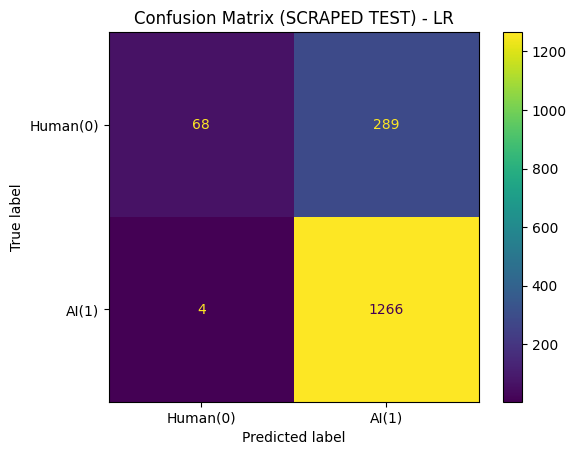


=== Per-source performance on SCRAPED TEST (min_n=20) ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:442: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1131: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:442: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:442: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1131: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_r

,source,n,acc,prec,rec,f1,roc_auc,pr_auc
1,chatgpt,1270,0.9969,1.0,0.9969,0.9984,NaN,1.0
0,arxiv,63,0.0000,0.0,0.0000,0.0000,NaN,0.0
2,news,98,0.2857,0.0,0.0000,0.0000,NaN,0.0
3,wikipedia,196,0.2041,0.0,0.0000,0.0000,NaN,0.0


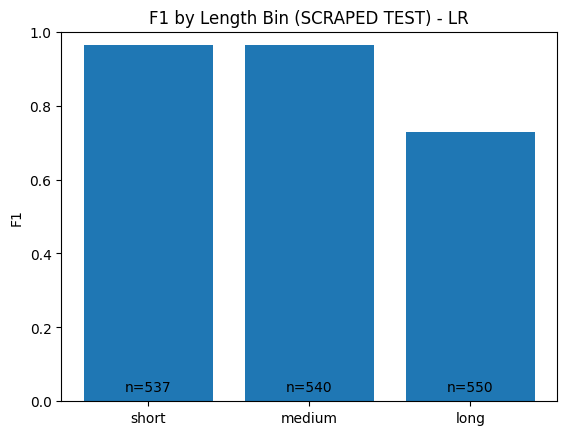

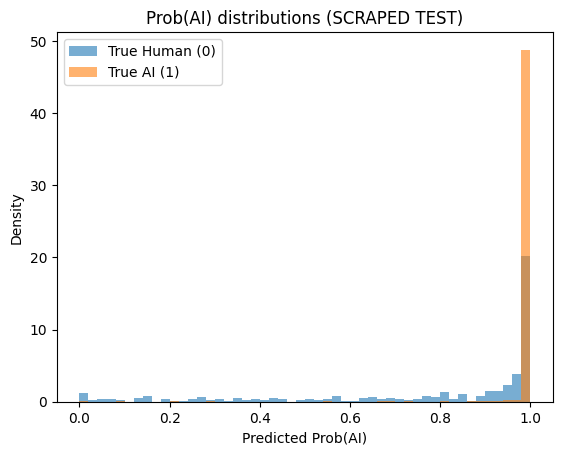

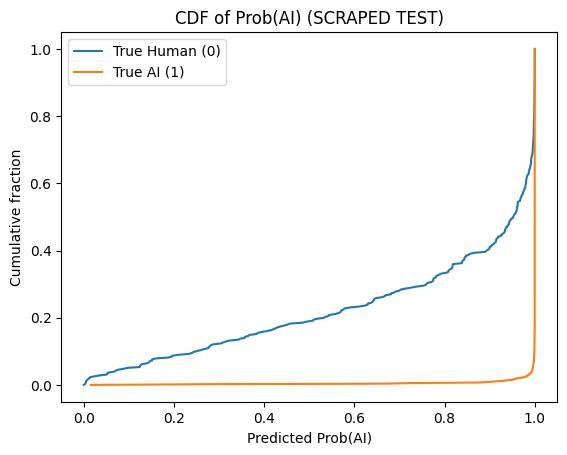

In [ ]:
# =========================
# DASHBOARD: LR (TF-IDF + Stylometry) interpretability
# No custom input here.
#
# Requires:
#   lr_pipe, val_all, test_all
#   val_df, test_df (must include 'text' and 'source')
#   y_val, y_test (numpy arrays)
#   style_cols (list)
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, average_precision_score
)

def _metrics(y_true, y_pred, y_prob=None):
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    out = {"acc": accuracy_score(y_true, y_pred), "prec": p, "rec": r, "f1": f1}
    if y_prob is not None:
        try: out["roc_auc"] = roc_auc_score(y_true, y_prob)
        except Exception: out["roc_auc"] = np.nan
        try: out["pr_auc"]  = average_precision_score(y_true, y_prob)
        except Exception: out["pr_auc"]  = np.nan
    return out

def prob_ai(model, X):
    if not hasattr(model, "predict_proba"):
        raise ValueError("Dashboard expects a model with predict_proba (Logistic Regression).")
    return model.predict_proba(X)[:, 1]

def length_bins(texts: pd.Series, q=(0.33, 0.66)):
    lens = texts.astype(str).str.len()
    q1, q2 = lens.quantile(list(q)).values
    return pd.cut(lens, [-np.inf, q1, q2, np.inf], labels=["short","medium","long"]).astype(str)

def plot_confidence_distributions(y_true, p_ai, title_suffix=""):
    p_h = p_ai[y_true == 0]
    p_a = p_ai[y_true == 1]

    bins = np.linspace(0, 1, 51)

    fig, ax = plt.subplots()
    ax.hist(p_h, bins=bins, alpha=0.6, density=True, label="True Human (0)")
    ax.hist(p_a, bins=bins, alpha=0.6, density=True, label="True AI (1)")
    ax.set_title(f"Prob(AI) distributions (SCRAPED TEST){title_suffix}")
    ax.set_xlabel("Predicted Prob(AI)")
    ax.set_ylabel("Density")
    ax.legend()
    plt.show()

    def cdf(vals):
        v = np.sort(vals)
        y = np.linspace(0, 1, len(v), endpoint=True)
        return v, y

    hx, hy = cdf(p_h)
    axx, ayy = cdf(p_a)

    fig, ax = plt.subplots()
    ax.plot(hx, hy, label="True Human (0)")
    ax.plot(axx, ayy, label="True AI (1)")
    ax.set_title(f"CDF of Prob(AI) (SCRAPED TEST){title_suffix}")
    ax.set_xlabel("Predicted Prob(AI)")
    ax.set_ylabel("Cumulative fraction")
    ax.legend()
    plt.show()

def plot_length_bin_f1(df_text, y_true, p_ai, title):
    bins = length_bins(df_text["text"])
    y_pred = (p_ai >= 0.5).astype(int)

    labels = ["short","medium","long"]
    f1s, counts = [], []
    for b in labels:
        m = (bins == b).values
        counts.append(int(m.sum()))
        if m.sum() == 0:
            f1s.append(np.nan)
        else:
            _, _, f1, _ = precision_recall_fscore_support(y_true[m], y_pred[m], average="binary", zero_division=0)
            f1s.append(float(f1))

    fig, ax = plt.subplots()
    ax.bar(labels, f1s)
    ax.set_ylim(0, 1)
    ax.set_ylabel("F1")
    ax.set_title(title)
    for i, c in enumerate(counts):
        ax.text(i, 0.02, f"n={c}", ha="center", va="bottom")
    plt.show()

def per_source_table(test_df, y_true, p_ai, min_n=20):
    y_pred = (p_ai >= 0.5).astype(int)
    rows = []
    for src, idx in test_df.groupby("source").indices.items():
        idx = np.array(list(idx))
        if len(idx) < min_n:
            continue
        m = _metrics(y_true[idx], y_pred[idx], p_ai[idx])
        rows.append({"source": src, "n": len(idx), **m})
    out = pd.DataFrame(rows).sort_values("f1", ascending=False)
    print(f"\n=== Per-source performance on SCRAPED TEST (min_n={min_n}) ===")
    display(out.round(4))
    return out

# def show_lr_top_features(lr_pipe, style_cols, topk=25):
#     tfidf_vec = lr_pipe.named_steps["features"].named_transformers_["tfidf"]
#     tfidf_names = tfidf_vec.get_feature_names_out()
#     feature_names = np.concatenate([tfidf_names, np.array(style_cols, dtype=object)])

#     coef = lr_pipe.named_steps["clf"].coef_[0]
#     dfc = pd.DataFrame({"feature": feature_names, "coef": coef})

#     print(f"\n🔴 Top {topk} AI-indicative features (positive coef)")
#     display(dfc.sort_values("coef", ascending=False).head(topk))

#     print(f"\n🔵 Top {topk} Human-indicative features (negative coef)")
#     display(dfc.sort_values("coef", ascending=True).head(topk))

#     style_only = dfc.iloc[len(tfidf_names):].copy()
#     print("\n🧠 Stylometry-only drivers (AI side)")
#     display(style_only.sort_values("coef", ascending=False).head(min(15, len(style_only))))

#     print("\n🧠 Stylometry-only drivers (Human side)")
#     display(style_only.sort_values("coef", ascending=True).head(min(15, len(style_only))))

# ---- Compute probabilities ----
val_p = prob_ai(lr_pipe, val_all)
test_p = prob_ai(lr_pipe, test_all)

val_pred = (val_p >= 0.5).astype(int)
test_pred = (test_p >= 0.5).astype(int)

# ---- Compact metrics ----
rows = [
    {"model":"LR (TF-IDF+Style)", "split":"VAL",  **_metrics(np.array(y_val),  val_pred,  val_p)},
    {"model":"LR (TF-IDF+Style)", "split":"TEST", **_metrics(np.array(y_test), test_pred, test_p)},
]
metrics_df = pd.DataFrame(rows)
print("\n=== Compact metrics ===")
display(metrics_df.round(4))

# ---- Confusion matrix (scraped test) ----
cm = confusion_matrix(np.array(y_test), test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["Human(0)","AI(1)"])
fig, ax = plt.subplots()
disp.plot(ax=ax, values_format="d")
ax.set_title("Confusion Matrix (SCRAPED TEST) - LR")
plt.show()

# ---- Per-source table (scraped test) ----
per_source_table(test_df.reset_index(drop=True), np.array(y_test), test_p, min_n=20)

# ---- Length-bin performance (scraped test) ----
plot_length_bin_f1(test_df.reset_index(drop=True), np.array(y_test), test_p,
                   "F1 by Length Bin (SCRAPED TEST) - LR")

# ---- Confidence distributions (scraped test) ----
plot_confidence_distributions(np.array(y_test), test_p)

# ---- Coefficient interpretability ----
# show_lr_top_features(lr_pipe, style_cols, topk=25)

# Expose test_p so Cell B can reuse it without recomputing
TEST_PROB_AI = test_p

In [ ]:
# =========================
# INTERACTIVE CUSTOM INPUT TESTER (LogReg TF-IDF + Stylometry)
# Single-cell, notebook-friendly
#
# Requires (already defined in notebook):
#   lr_pipe
#   style_cols
#   compute_all_features_final()
#   TEST_PROB_AI        (from dashboard cell)
#   y_test              (scraped test labels)
#
# If widgets do not render:
#   pip install ipywidgets
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display, clear_output


# ---------- helper: overlay confidence marker ----------
def _plot_conf_dist_with_marker(y_true, p_ai, marker_prob):
    p_h = p_ai[y_true == 0]
    p_a = p_ai[y_true == 1]
    bins = np.linspace(0, 1, 51)

    fig, ax = plt.subplots()
    ax.hist(p_h, bins=bins, alpha=0.6, density=True, label="True Human (0)")
    ax.hist(p_a, bins=bins, alpha=0.6, density=True, label="True AI (1)")
    ax.axvline(marker_prob, linestyle="--", linewidth=2, color="black")
    ax.text(marker_prob, ax.get_ylim()[1]*0.95, "Custom input",
            rotation=90, va="top", ha="right")
    ax.set_title("Prob(AI) distribution on SCRAPED TEST")
    ax.set_xlabel("Predicted Prob(AI)")
    ax.set_ylabel("Density")
    ax.legend()
    plt.show()


# ---------- core prediction ----------
def _run_custom_prediction(text, max_lines, top_k, overlay):
    feats = compute_all_features_final(text, max_lines=max_lines)

    row = {c: float(feats.get(c, 0.0)) for c in style_cols}
    row["text"] = text
    X_one = pd.DataFrame([row])

    prob_ai = float(lr_pipe.predict_proba(X_one)[:, 1][0])
    pred = int(prob_ai >= 0.5)
    conf = prob_ai if pred == 1 else (1 - prob_ai)

    print("Prediction:", "AI (1)" if pred == 1 else "Human (0)")
    print(f"Prob(AI):   {prob_ai:.4f}")
    print(f"Confidence: {conf:.4f}")

    # ---- show key stylometry (interpretable) ----
    print("\n--- Stylometric summary ---")
    for k in [
        "num_words","num_sentences","avg_sentence_length",
        "type_token_ratio","pct_punct",
        "sentence_length_std","bigram_repetition_ratio"
    ]:
        if k in feats:
            print(f"{k}: {feats[k]}")

    # ---- per-sample LR contributions ----
    try:
        features = lr_pipe.named_steps["features"]
        tfidf_vec = features.named_transformers_["tfidf"]
        tfidf_names = tfidf_vec.get_feature_names_out()

        X_trans = features.transform(X_one).tocoo()
        coef = lr_pipe.named_steps["clf"].coef_[0]
        contrib = X_trans.data * coef[X_trans.col]

        feature_names = np.concatenate([tfidf_names, np.array(style_cols, dtype=object)])
        order = np.argsort(np.abs(contrib))[::-1][:top_k]

        print(f"\n--- Top {top_k} feature contributions ---")
        for i in order:
            fname = feature_names[X_trans.col[i]]
            print(f"{fname}: {contrib[i]:+.6f}")
    except Exception as e:
        print("\n(Contribution breakdown skipped:", e, ")")

    # ---- overlay marker on TEST distribution ----
    if overlay:
        _plot_conf_dist_with_marker(np.array(y_test), TEST_PROB_AI, prob_ai)


# ---------- widgets UI ----------
text_box = widgets.Textarea(
    placeholder="Paste text here...",
    layout=widgets.Layout(width="100%", height="180px")
)

max_lines_slider = widgets.IntSlider(
    value=5, min=1, max=50, step=1,
    description="max_lines"
)

topk_slider = widgets.IntSlider(
    value=12, min=5, max=30, step=1,
    description="top_k"
)

overlay_checkbox = widgets.Checkbox(
    value=True,
    description="Overlay on TEST confidence plot"
)

run_button = widgets.Button(
    description="Predict",
    button_style="primary"
)

output = widgets.Output()

def on_run(_):
    with output:
        clear_output(wait=True)
        txt = text_box.value.strip()
        if not txt:
            print("Please paste some text.")
            return
        _run_custom_prediction(
            txt,
            max_lines_slider.value,
            topk_slider.value,
            overlay_checkbox.value
        )

run_button.on_click(on_run)

display(
    text_box,
    widgets.HBox([max_lines_slider, topk_slider, overlay_checkbox, run_button]),
    output
)

Textarea(value='', layout=Layout(height='180px', width='100%'), placeholder='Paste text here...')

Output()

In [1]:
from pathlib import Path
import json

ART_DIR = Path("/content/drive/MyDrive/artifacts/lstm_style_v1")
ART_DIR.mkdir(parents=True, exist_ok=True)

# These should already exist in your ML notebook:
# train_all, val_all, test_all  (DataFrames with 'text' + style feature columns)
# y_train, y_val, y_test
# style_cols (list of stylometry column names)

# --- sanity checks ---
for name, df in [("train_all", train_all), ("val_all", val_all), ("test_all", test_all)]:
    missing = [c for c in ["text"] + style_cols if c not in df.columns]
    if missing:
        raise ValueError(f"{name} missing columns: {missing[:10]}{'...' if len(missing)>10 else ''}")

# --- keep only what LSTM needs ---
train_export = train_all[["text"] + style_cols].copy()
val_export   = val_all[["text"] + style_cols].copy()
test_export  = test_all[["text"] + style_cols].copy()

train_export["label"] = y_train
val_export["label"]   = y_val
test_export["label"]  = y_test

# --- save datasets ---
try:
    train_export.to_parquet(ART_DIR / "train_all.parquet", index=False)
    val_export.to_parquet(ART_DIR / "val_all.parquet", index=False)
    test_export.to_parquet(ART_DIR / "test_all.parquet", index=False)
    fmt = "parquet"
except Exception as e:
    print("Parquet failed, falling back to CSV. Error:", e)
    train_export.to_csv(ART_DIR / "train_all.csv", index=False)
    val_export.to_csv(ART_DIR / "val_all.csv", index=False)
    test_export.to_csv(ART_DIR / "test_all.csv", index=False)
    fmt = "csv"

# --- save metadata (style column order is critical) ---
meta = {
    "format": fmt,
    "style_cols": style_cols
}
with open(ART_DIR / "meta.json", "w") as f:
    json.dump(meta, f)

print("✅ Exported text+stylometry datasets to:", ART_DIR)
print("Format:", fmt)
print("Train shape:", train_export.shape, "Val shape:", val_export.shape, "Test shape:", test_export.shape)

NameError: name 'train_all' is not defined